# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определяем, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Пронин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

Автоматическая инициализация членов класса параметрами конструктора:

In [3]:
import inspect
import functools

def autoargs(*include,**kwargs):   
    def _autoargs(func):
        attrs,varargs,varkw,defaults=inspect.getargspec(func)
        def sieve(attr):
            if kwargs and attr in kwargs['exclude']: return False
            if not include or attr in include: return True
            else: return False            
        @functools.wraps(func)
        def wrapper(self,*args,**kwargs):
            # handle default values
            for attr,val in zip(reversed(attrs),reversed(defaults)):
                if sieve(attr): setattr(self, attr, val)
            # handle positional arguments
            positional_attrs=attrs[1:]            
            for attr,val in zip(positional_attrs,args):
                if sieve(attr): setattr(self, attr, val)
            # handle varargs
            if varargs:
                remaining_args=args[len(positional_attrs):]
                if sieve(varargs): setattr(self, varargs, remaining_args)                
            # handle varkw
            if kwargs:
                for attr,val in kwargs.iteritems():
                    if sieve(attr): setattr(self,attr,val)            
            return func(self,*args,**kwargs)
        return wrapper
    return _autoargs

In [26]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.utils.multiclass import unique_labels

class MiniBatchSGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    def __init__(self, C=1., alpha=0.1, max_epoch=10, batch_size=3, log_costs=False, random_state=None):
        self.__dict__.update(locals())
        del self.self
        self._validate_params()
        
    def _validate_params(self):
        if self.C <= 0:
            raise ValueError("Penalty term C must be positive (set %f)" % (self.C))
        if self.alpha < 0:
            raise ValueError("alpha must be >= 0 (set %f)" % (self.alpha))
        if self.max_epoch <= 0:
            raise ValueError("max_epoch must be positive (set %d)" % (self.max_epoch))
        if self.batch_size <= 0:
            raise ValueError("batch_size must be positive (set %d)" % (self.batch_size))
        if self.random_state is not None and (self.random_state < 0 \
                                               or self.random_state > 4294967295):
            raise ValueError("random_state must be between 0 and 4294967295");
    
    def _is_fitted(self, raise_exception=False):
        try:
            check_is_fitted(self, ['X_', 'y_'])
            return True
        except NotFittedError:
            if raise_exception:
                raise
            return False
        
    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def _cost_function(self, X, y, w):
        cost = -np.average(np.log(self._sigmoid(y * np.dot(X, w.T))), axis=0)
        L2_reg = (self.C / (2 * X.shape[0])) * np.sum(np.power(w, 2), axis=0)
        return cost + L2_reg
    
    def _gradient(self, X, y, w):
        grad = -np.average((y[:, np.newaxis] * X) * self._sigmoid(-y * np.dot(X, w.T))[:, np.newaxis],
                           axis=0)
        w[0] = 0
        L2_reg = (self.C / X.shape[0]) * w
        return grad + L2_reg
    
    def _get_batches(self, perm, batch_size):
        batches_num = perm.shape[0] / batch_size + (1 if perm.shape[0] % batch_size else 0)
        return np.array_split(perm, batches_num)

    def fit(self, X, y):
        # Check X and y and that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Add column of ones to X (free terms)
        X = np.c_[np.ones(X.shape[0]), X]
        
        # Check batch_size
        if self.batch_size > X.shape[0]:
            warnings.warn("Batch size is greater than number of samples in X, so it set to \
            number of samples in X");
            self.batch_size = X.shape[0]
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Check if there are exactly two classes
        if self.classes_.shape[0] != 2:
            raise ValueError("This classifier implemented only for two classes \
            (or check if y is a vector of two classes labels)");
        
        # Convert y labels to +1 and -1
        y = np.copy(y)
        y[y == self.classes_[0]] = -1
        y[y == self.classes_[1]] = 1
        
        # Seed random
        np.random.seed(self.random_state)
        
        if not self._is_fitted():
            self.weights_ = np.random.uniform(-1.0 / X.shape[1], 1.0 / X.shape[1], X.shape[1])
        new_weights = np.copy(self.weights_)
        self.costs_log_ = []
        for epoch in xrange(self.max_epoch):
            perm = np.random.permutation(X.shape[0])
            for batch_n, batch in enumerate(self._get_batches(perm, self.batch_size), 1):
                new_weights -= (self.alpha / (epoch + 1)) * self._gradient(X[batch], y[batch], 
                                                                           self.weights_)
                self.weights_ = np.copy(new_weights)
            if self.log_costs:
                self.costs_log_.append(self._cost_function(X, y, self.weights_))
        
        self.X_ = X
        self.y_ = y
        print "Fitted with params:", self.get_params()
        
        return self
    
    def partial_fit(self, X, y):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        if not self._is_fitted():
            warnings.warn("Model not fitted yet, so partial fit will be initial fit\n");
            return self.fit(X, y)
        # Check if number of features in additional dataset the same as while fitting the model
        if X.shape[1] + 1 != self.X_.shape[1]:
            raise ValueError("Additional dataset and initial fit dataset must have \
                             equal number of features");
        return self.fit(X, y)

    def predict_proba(self, X):
        # Check is fit had been called
        self._is_fitted(raise_exception=True)
        
        # Input validation
        X = check_array(X)
        
        # add column of ones
        X = np.c_[np.ones(X.shape[0]), X]
        
        # build classes probabilities classes
        y = np.zeros((X.shape[0], 2), dtype=np.float64)
        y[:,1] = self._sigmoid(np.dot(X, self.weights_.T))
        y[:,0] = 1.0 - y[:,1]
        
        return y
    
    def predict(self, X):
        # Check is fit had been called
        self._is_fitted(raise_exception=True)
        
        # Input validation
        X = check_array(X)
        
        # add column of ones
        X = np.c_[np.ones(X.shape[0]), X]
        
        # build classes predictions vector
        y_hat = np.sign(np.dot(X, self.weights_.T))
        y_hat[y_hat == -1] = self.classes_[0]
        y_hat[y_hat == 1] = self.classes_[1]
        
        return y_hat

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [8]:
np.random.seed(42)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1_1 = np.dot(np.random.randn(200, 2) + np.array([-3, -1]), C1)
gauss1_2 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X_1 = np.vstack([gauss1_1, gauss2])
X_2 = np.vstack([gauss1_2, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': False, 'alpha': 0.5}
Weights: [-0.74667354 -1.51741203  2.84186083]
Accuracy: 0.9875
ROCAUC:   0.99985


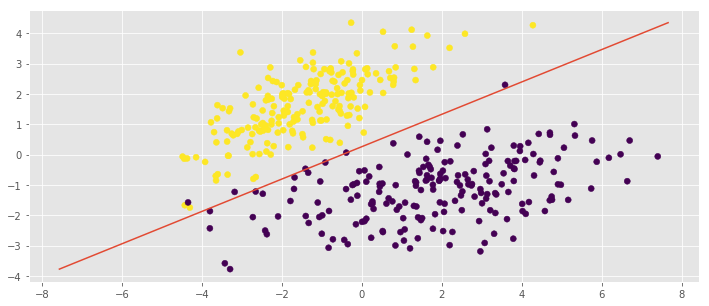

In [9]:
clf_1 = MiniBatchSGDClassifier(C = 0.01, alpha=0.5, batch_size=3, max_epoch=100, random_state=42)
clf_1.fit(X_1[:300,:],y[:300])
print "Weights:", clf_1.weights_
print "Accuracy:", accuracy_score(y, clf_1.predict(X_1))
print "ROCAUC:  ", roc_auc_score(y, clf_1.predict_proba(X_1)[:,1])

plt.scatter(X_1[:,0], X_1[:,1], c=y)
min_max = np.array([X_1[:,1].min(), X_1[:,1].max()])
plt.plot(-(min_max * clf_1.weights_[2] + clf_1.weights_[0]) / clf_1.weights_[1], min_max)   

Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': False, 'alpha': 0.5}
Updated weights: [-1.70411346 -1.62192559  2.90377519]
Accuracy: 0.9975
ROCAUC:   0.99985


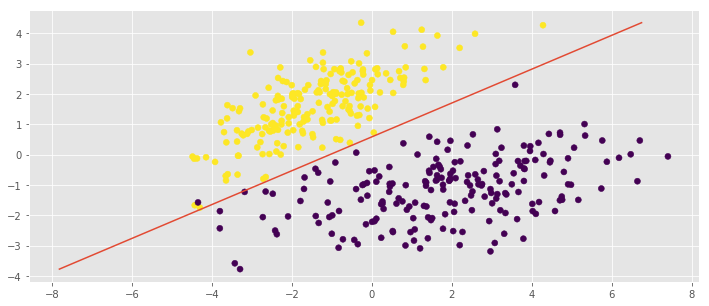

In [10]:
clf_1.partial_fit(X_1[100:,:],y[100:])
print "Updated weights:", clf_1.weights_
print "Accuracy:", accuracy_score(y, clf_1.predict(X_1))
print "ROCAUC:  ", roc_auc_score(y, clf_1.predict_proba(X_1)[:,1])

plt.scatter(X_1[:,0], X_1[:,1], c=y)
min_max = np.array([X_1[:,1].min(), X_1[:,1].max()])
plt.plot(-(min_max * clf_1.weights_[2] + clf_1.weights_[0]) / clf_1.weights_[1], min_max)  

Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': False, 'alpha': 0.5}
Weights: [-6.25909771  1.26000675 -1.451504  ]


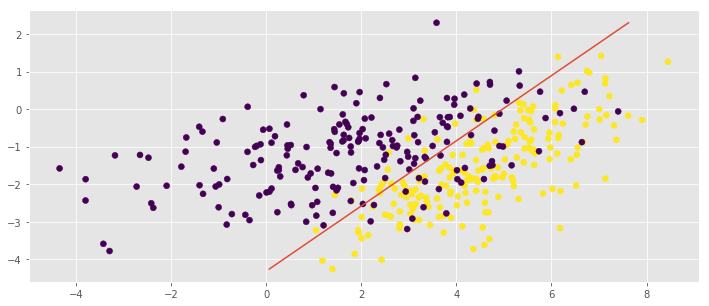

In [11]:
clf_2 = MiniBatchSGDClassifier(C = 0.01, alpha=0.5, batch_size=3, max_epoch=100, random_state=42)
clf_2.fit(X_2,y)
print "Weights:", clf_2.weights_

plt.scatter(X_2[:,0], X_2[:,1], c=y)
min_max = np.array([X_2[:,1].min(), X_2[:,1].max()])
plt.plot(-(min_max * clf_2.weights_[2] + clf_2.weights_[0]) / clf_2.weights_[1], min_max)   

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': True, 'alpha': 0.005}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': True, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': True, 'alpha': 0.5}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': True, 'alpha': 1.0}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': True, 'alpha': 2.0}


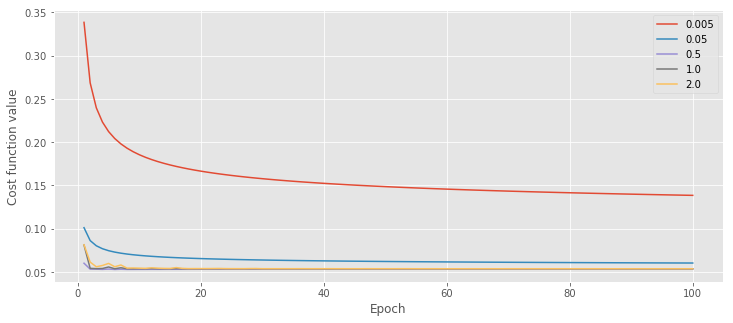

In [12]:
for alpha in (0.005, 0.05, 0.5, 1.0, 2.0):
    clf = MiniBatchSGDClassifier(C=0.01, alpha=alpha, max_epoch=100, batch_size=3,
                                 log_costs=True, random_state=42).fit(X_1, y)
    plt.plot(xrange(1, len(clf.costs_log_) + 1), clf.costs_log_, label=str(alpha))
plt.xlabel(u'Epoch')
plt.ylabel(u'Cost function value')
plt.legend()

Как видно из графика, при маленьких alpha алгоритм попадает в локальный минимум. При alpha = 0.5 достигается минимальная ошибка при увеличении числа эпох. Однако, выборка практически целиком линейно разделима, поэтому при более-менее удачных (больших) alpha достигается точность в почти 100%. Правило уменьшения alpha: cur_alpha = alpha/epoch - благодаря этому правилу мы не получаем "блужданий" при работа алгоритма.

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

Загружаем все тренировочные данные

In [30]:
# load all training data from all 4 chunks
df_list = []
for chunk in xrange(1,5):
    filepath = './csv/trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))

df_train_data = pd.concat(df_list)

# for better usage of training data
df_train_data.columns = df_train_data.columns.str.replace('.', '_')
df_train_data = df_train_data.set_index('gamestate_id')

# collect garbage due to memory economy
del df_list
gc.collect()

print "Training data shape: ", df_train_data.shape
print "Classes distribution:", df_train_data.decision.mean()
#df_train_data.head().T

Training data shape:  (2000000, 44)
Classes distribution: 0.5047995


#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

Категориальные признаки - это player_hero_card_id и opponent_hero_card_id.</br>
Проверка ниже показала, все возможные значения категориальных переменных содержатся в тренировочном наборе и множества этих значений в тренировочном и тестовом наборах совпадают.

In [31]:
#print set(df_train_data.player_hero_card_id.unique()) - set(df_test_data.player_hero_card_id.unique())
#print set(df_train_data.opponent_hero_card_id.unique()) - set(df_test_data.opponent_hero_card_id.unique())

Определим количество уникальных карт героя у игрока и оппонента, а также эти карты:

In [32]:
player_cards = df_train_data.player_hero_card_id.unique()
opponent_cards = df_train_data.opponent_hero_card_id.unique()
print "Player`s unique cards:", player_cards
print "Player`s unique cards count:", player_cards.shape[0]
print "Opponent`s unique cards:", opponent_cards
print "Opponent`s unique cards count:", opponent_cards.shape[0]

Player`s unique cards: [ 981  754  612  494   25 1235  326  390  798]
Player`s unique cards count: 9
Opponent`s unique cards: [ 798  754  612  390   25 1235  494  981  326]
Opponent`s unique cards count: 9


Векторизуем с помощью OneHotEncoder категориальные признаки, добавим их в датасет, и удалим старые признаки.

In [33]:
player_columns = ["player_hero_card_id_" + "%d" % n for n in xrange(1, player_cards.shape[0] + 1)]
opponent_columns = ["opponent_hero_card_id_" + "%d" % n for n in xrange(1, opponent_cards.shape[0] + 1)]

In [34]:
player_values_train = OneHotEncoder().fit_transform(
    df_train_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)
opponent_values_train = OneHotEncoder().fit_transform(
    df_train_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)
df_train_data = pd.concat([df_train_data,
                           pd.DataFrame(player_values_train, columns=player_columns,
                                        index=df_train_data.index),
                           pd.DataFrame(opponent_values_train, columns=opponent_columns,
                                        index=df_train_data.index)],
                           axis=1)

# drop old features
df_train_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)
print "New training data shape is:", df_train_data.shape

# collect garbage due to memory economy
del player_values_train
del opponent_values_train
gc.collect()

#df_train_data.head().T

New training data shape is: (2000000, 60)


14

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

Получаем матрицу наблюдений X и вектор целевого признака y

In [35]:
X = df_train_data.iloc[:,1:].values
y = df_train_data.iloc[:,0].values
print X.shape, y.shape

# collect garbage due to memory economy
del df_train_data
gc.collect()

(2000000L, 59L) (2000000L,)


34

Нормализуем данные:

In [36]:
X = StandardScaler().fit_transform(X)

# collect garbage due to memory economy
gc.collect()

X[:10,:5]

array([[ 1.16292076, -0.25878141, -0.2706061 , -1.93569616, -0.27062792],
       [-0.39967732, -0.25878141, -0.2706061 ,  0.08838259, -0.27062792],
       [-0.84613392,  2.56170396, -0.2706061 ,  0.92182678, -0.27062792],
       [-0.17644902, -0.25878141, -0.2706061 ,  0.56463641, -0.27062792],
       [ 0.93969247, -0.25878141, -0.2706061 ,  1.04089024, -0.27062792],
       [ 0.93969247, -0.25878141, -0.2706061 ,  0.56463641, -0.27062792],
       [ 0.04677928, -0.25878141, -0.2706061 , -0.14974432, -0.27062792],
       [-1.51581881, -0.25878141, -0.2706061 ,  1.04089024, -0.27062792],
       [ 0.71646417,  1.62154217, -0.2706061 , -0.38787123, -0.27062792],
       [ 0.27000757, -0.25878141, -0.2706061 , -0.62599815, -0.27062792]])

Разбиваем тренировочные данные на небольшие обучающую и тестовую подвыборки:

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.0075, test_size=0.0025,
                                                    stratify=y, random_state=42)
print "Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape
print "Train classes distribution:", y_train.mean()
print "Test classes distribution: ", y_test.mean()

# collect garbage due to memory economy
gc.collect()

Shapes: (15000L, 59L) (5000L, 59L) (15000L,) (5000L,)
Train classes distribution: 0.5048
Test classes distribution:  0.5048


0

Подбираем наилучшие параметры модели с помощью GridSearchCV:

In [21]:
param_grid = {'C': [0.01, 0.1, 1.0, 10.0], 
              'alpha': [0.05, 0.5, 1.0, 2.0],
              'batch_size': [2, 3, 5, 10]}
clf = MiniBatchSGDClassifier(max_epoch=100, random_state=42)
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=1)
gs.fit(X_train, y_train)

Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C'

C:\Dev\Python\2\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: overflow encountered in exp


Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 1.0}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 1.0}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 1.0}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 1.0}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 1.0}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': False, 'alpha': 1.0}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': False, 'alpha': 1.0}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 3, 'random_state': 42, 'log_costs': False, 'alpha': 1.0}
Fitted with params: {'C': 0.01, 

GridSearchCV(cv=5, error_score='raise',
       estimator=MiniBatchSGDClassifier(C=1.0, alpha=0.1, batch_size=3, log_costs=False,
            max_epoch=100, random_state=42),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.05, 0.5, 1.0, 2.0], 'C': [0.01, 0.1, 1.0, 10.0], 'batch_size': [2, 3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [22]:
clf = gs.best_estimator_
best_params = gs.best_params_
best_score = gs.best_score_
print best_params, best_score

{'alpha': 0.05, 'C': 0.01, 'batch_size': 2} 0.791588949175


In [ ]:
for epoch in (50, 100, 500, 1000):
    clf_epoch = MiniBatchSGDClassifier(C=0.01, alpha=0.05, max_epoch=epoch, batch_size=2)
    clf_epoch.fit(X_train, y_train)
    print "Epoch:", epoch
    print "ROCAUC score:", roc_auc_score(y_test, clf_epoch.predict_proba(X_test)[:,1])
    print "Accuracy:    ", accuracy_score(y_test, clf_epoch.predict(X_test))

Epoch: 50<br>
ROCAUC score: 0.788635720668<br>
Accuracy:     0.7018<br>
Epoch: 100<br>
ROCAUC score: 0.789318983638<br>
Accuracy:     0.7036<br>
Epoch: 500<br>
ROCAUC score: 0.789523962528<br>
Accuracy:     0.7036<br>
Epoch: 1000<br>
ROCAUC score: 0.789495639918<br>
Accuracy:     0.7022<br>
Как видно, начиная со 100, число эпох не сильно влияет на качество классификации (видимо, из-за быстрой сходимости алгоритма при заданном alpha)

Наилучшие найденные параметры: {'alpha': 0.05, 'C': 0.01, 'batch_size': 2}, max_epoch=100 <br>
ROCAUC оценка модели при наилучших параметрах: 0.791588949175

Обучим модель на всех тренировочных данных, используя найденные наилучшие параметры.

In [38]:
# collect garbage due to memory economy
del X_train 
del X_test
del y_train
del y_test
gc.collect()

0

In [39]:
chunk_size = 100000
n_iters = X.shape[0] / chunk_size
clf = MiniBatchSGDClassifier(C=0.01, alpha=0.05, max_epoch=100, batch_size=2, random_state=42)
clf.fit(X[:chunk_size],y[:chunk_size])
gc.collect()

Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}


48

In [40]:
for chunk in xrange(2, n_iters + 1):
    bottom = chunk_size * (chunk - 1)
    upper = chunk_size * chunk
    clf.partial_fit(X[bottom:upper], y[bottom:upper])
    gc.collect()

Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C': 0.01, 'max_epoch': 100, 'batch_size': 2, 'random_state': 42, 'log_costs': False, 'alpha': 0.05}
Fitted with params: {'C'

In [42]:
clf.weights_

array([ 0.06905371,  0.21865284, -0.01449466, -0.0275019 , -0.59814751,
        0.09291085,  0.02341633, -0.06064609,  0.07299866, -0.08612634,
        0.04665602, -0.33223722, -0.00720883, -0.0095812 ,  0.02771938,
        0.56140426, -0.04624187, -0.00956779, -0.22611095,  0.07668068,
        0.13700461, -0.07533532,  0.02428211, -0.04194825, -0.00720883,
       -0.33358999, -0.04868898, -0.28306393, -0.23423615, -0.04194825,
        0.43716809,  0.12252   ,  0.3346727 ,  0.22015383,  0.10082885,
       -0.07141812, -0.1080442 ,  0.02428211,  0.00680179,  0.10681856,
        0.14281485,  0.08840435, -0.09322843,  0.05380268, -0.06058595,
        0.01453918,  0.02401257,  0.03048938,  0.07879171, -0.04109952,
       -0.00480933,  0.04012973, -0.0437925 ,  0.01233135, -0.02326782,
       -0.03934892,  0.04373039, -0.07441999,  0.03272356,  0.05724035])

In [44]:
del X
gc.collect()

9

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

Загружаем тестовые данные, и преобразуем их для применения модели:

In [45]:
# load test data
df_test_data = pd.read_csv('./csv/testData_tabular.csv')
# for better usage of test data
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')
print "Test data shape:", df_test_data.shape

# vectorize categorial features
player_values_test = OneHotEncoder().fit_transform(
    df_test_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)
opponent_values_test = OneHotEncoder().fit_transform(
    df_test_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)
df_test_data = pd.concat([df_test_data,
                           pd.DataFrame(player_values_test, columns=player_columns,
                                        index=df_test_data.index),
                           pd.DataFrame(opponent_values_test, columns=opponent_columns,
                                        index=df_test_data.index)],
                           axis=1)

# drop old features
df_test_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)
print "New test data shape is:", df_test_data.shape

# collect garbage due to memory economy
del player_values_test
del opponent_values_test
gc.collect()

#df_test_data.head().T

Test data shape: (750000, 44)
New test data shape is: (750000, 60)


28

Получаем матрицу наблюдений X_test:

In [46]:
X_test = df_test_data.iloc[:,1:].values
print X_test.shape

# collect garbage due to memory economy
del df_test_data
gc.collect()

(750000L, 59L)


25

Нормализуем тестовые данные:

In [47]:
X_test = StandardScaler().fit_transform(X_test)

# collect garbage due to memory economy
gc.collect()

0

Получаем предсказания для тестовых данных с помощью обученной модели с наилушими подобранными параметрами:

In [48]:
scores = clf.predict_proba(X_test)[:,1]
scores.shape

(750000L,)

Сохраняем результат в текстовый файл для отправки в оценивающую систему на сайт:

In [49]:
suffix = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
np.savetxt("./scores/hearthstone_scores_%s.txt" % suffix, scores, fmt='%.18f')

Username и результаты в leaderboard:<br>
sergotail<br>
0.7902